In [1]:
%matplotlib inline

In [2]:
import sys
sys.path.append("../../ilqr")
sys.path.append("../../")

In [3]:
import numpy as np
import torch

import matplotlib.pyplot as plt
from torchdyn.models import NeuralODE

from cartpole import GeneralDyanmic, PendulumDynamic
from cost import QRCost
from controller import iLQR

from dynamic import constrain
np.set_printoptions(suppress=True)

In [4]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = PendulumDynamic.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [5]:
models = torch.load("../Pendulum/model/gradvsODEvsFD_new.pt")
lagODE_model = torch.load("../Pendulum/model/gradvsODEvsFD_lagODE_new.pt")
models.insert(1, lagODE_model)

for model in models:
    model.eval()
None

In [6]:
dt = 0.05
np.set_printoptions(suppress=True)

device = 'cpu'
grad = NeuralODE(PendulumDynamic().to(device), sensitivity='adjoint', solver='rk4')

# dynamics = GeneralDyanmic(0.05, grad, state_size=3, action_size=1)
dynamics = GeneralDyanmic(0.05, models[1], state_size=3, action_size=1)

In [7]:
# Note that the augmented state is not all 0.
x_goal = PendulumDynamic.augment_state(np.array([0.0, 0.0]))
Q = np.eye(dynamics.state_size)
# Q[0, 1] = Q[1, 0] = pendulum_length
# Q[0, 0] = Q[1, 1] = pendulum_length**2
Q[2, 2] = 0.0
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[1.0]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 50
x0 = PendulumDynamic.augment_state(np.array([np.pi, 0.0]))
np.random.seed(0)
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=50, on_iteration=on_iteration)

iteration 0 accepted 599.8308173124532 [-3.0949666  -0.00188244]
iteration 1 accepted 599.5290384074983 [-3.06613408 -0.00013153]
iteration 2 accepted 598.7721414381609 [-3.01971242 -0.00009084]
iteration 3 accepted 596.8063675996533 [-2.94479523 -0.00000907]
iteration 4 accepted 591.7835824358975 [-2.82481091  0.00039445]
iteration 5 accepted 579.180241176888 [-2.63373034  0.00216049]
iteration 6 accepted 549.2176316334323 [-2.3342953   0.01075321]
iteration 7 accepted 486.6094248136783 [-1.88336626  0.04057193]
iteration 8 accepted 394.7585542248852 [-1.30416819  0.06424987]
iteration 9 accepted 328.1702342353545 [-0.82860687  0.09801716]
iteration 10 accepted 302.7614710445363 [-0.62558177  0.08338177]
iteration 11 accepted 293.1826789195327 [-0.50632016  0.08472985]
iteration 12 accepted 289.09796203121243 [-0.44854585  0.07771719]
iteration 13 accepted 286.63861352672325 [-0.40388233  0.07451057]
iteration 14 accepted 285.56714304392665 [-0.37681711  0.07282999]
iteration 15 accep

In [10]:
# Reduce the state to something more reasonable.
xs = PendulumDynamic.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, -2, 2)

In [11]:
t = np.arange(N) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

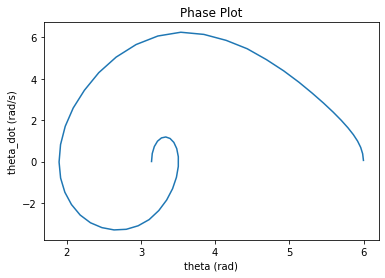

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

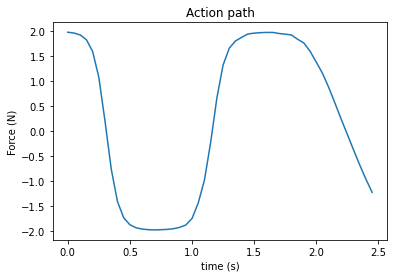

In [13]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

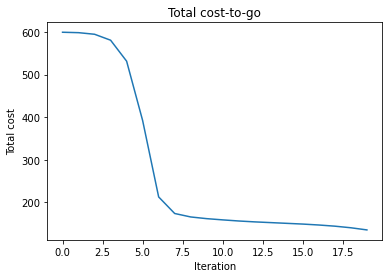

In [52]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")

In [53]:
from gym_env import PendulumCustomEnv

In [62]:
env = PendulumCustomEnv()
env.seed(0)
np.random.seed(0)
obs = []
infos = []

split = 20
controls = us
obs0, _ = env.reset(np.array([np.pi, 0]))

prev_obs = obs0
for i in range(50):
    obs.append(prev_obs)

    next_obs, reward, done, info = env.step(controls[i])
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    prev_obs = next_obs

<ipython-input-62-76d74db61edd>:16: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  infos.append(np.array([info['th'], info['dth'], info['ddth']]))


In [63]:
test_x = PendulumDynamic.reduce_state(np.array(obs))

t = np.arange(N) * dt
theta = np.unwrap(test_x[:, 0])  # Makes for smoother plots.
theta_dot = test_x[:, 1]

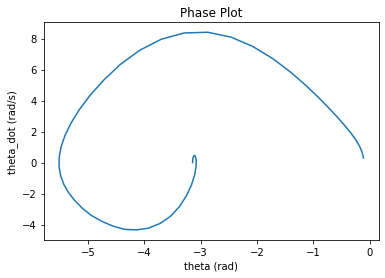

In [64]:
_ = plt.plot(theta[:100], theta_dot[:100])
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

In [67]:
# MPC
dynamics = GeneralDyanmic(0.05, models[2], state_size=3, action_size=1)
ilqr = iLQR(dynamics, cost, N)

In [68]:
env = PendulumCustomEnv()
env.seed(0)
np.random.seed(0)

all_us = []
all_xs = []
obs = []
infos = []

split = 20
obs0, _ = env.reset(np.array([np.pi, 0]))

prev_obs = obs0
last_us = us_init

for i in range(50):
    print(i)
    obs.append(prev_obs)
    xs, us = ilqr.fit(prev_obs, last_us, n_iterations=20, on_iteration=on_iteration)
    all_us.append(us)
    all_xs.append(xs)
    
    next_obs, reward, done, info = env.step(us[0])
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    
    prev_obs = next_obs
    last_us = us

0
iteration 0 accepted 599.6428095450276 [-3.08550296 -0.00175959]
iteration 1 accepted 598.646300258966 [-3.03156457 -0.00015652]
iteration 2 accepted 594.9022691793709 [-2.9251691  -0.00011389]
iteration 3 accepted 580.9251389276071 [-2.71764598  0.00025201]
iteration 4 accepted 531.6416501954951 [-2.31969757  0.00205904]
iteration 5 accepted 392.18540047871545 [-1.59981716  0.01171505]
iteration 6 accepted 212.72975002152765 [-0.60206863  0.00520229]
iteration 7 accepted 173.82862979751607 [-0.16861118  0.00867689]
iteration 8 accepted 165.68422556536828 [-0.13527291  0.03750831]
iteration 9 accepted 161.70336092336754 [-0.11287515  0.03301209]
iteration 10 accepted 158.81564301834027 [-0.09975457  0.02880019]
iteration 11 accepted 156.20499959214268 [-0.08971033  0.02614278]
iteration 12 accepted 154.11188585936333 [-0.08143693  0.02388561]
iteration 13 accepted 152.40119600180907 [-0.07480747  0.02213836]
iteration 14 accepted 150.67774394910123 [-0.06888045  0.02063984]
iteration

<ipython-input-68-a1c42dce7990>:24: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  infos.append(np.array([info['th'], info['dth'], info['ddth']]))


iteration 0 accepted 131.83211712697582 [-0.04277839  0.0185532 ]
iteration 1 accepted 126.52925602768975 [-0.05056911  0.01618755]
iteration 2 accepted 121.06352561269789 [-0.04638707  0.01527345]
iteration 3 accepted 118.22960979593748 [-0.04363829  0.01459584]
iteration 4 accepted 117.10955421572423 [-0.04188903  0.01414132]
iteration 5 accepted 116.76807348008144 [-0.04044788  0.01375708]
iteration 6 accepted 116.69024340733155 [-0.03930453  0.01342142]
iteration 7 accepted 116.66107148424015 [-0.03828732  0.01311851]
iteration 8 accepted 116.62232148867582 [-0.03724069  0.01282522]
iteration 9 accepted 116.60371095243575 [-0.03638459  0.01257256]
iteration 10 accepted 116.57538352492504 [-0.03564405  0.01235431]
iteration 11 accepted 116.56407823983392 [-0.03500878  0.01215333]
iteration 12 accepted 116.53598614129845 [-0.03427659  0.01194507]
iteration 13 accepted 116.52445812788588 [-0.0335272   0.01173109]
iteration 14 accepted 116.50114060749272 [-0.03292106  0.01154625]
itera

iteration 4 accepted 273.45734628896 [ 0.18202189 -0.07602262]
iteration 5 accepted 272.0443877343462 [ 0.16305656 -0.07436085]
iteration 6 accepted 271.5425660860341 [ 0.1640762  -0.07274544]
iteration 7 accepted 271.39668067925373 [ 0.15815523 -0.07260287]
iteration 8 accepted 271.16472073271467 [ 0.15802506 -0.07212269]
iteration 9 accepted 271.074755011716 [ 0.14722046 -0.07042634]
iteration 10 accepted 271.02852278074045 [ 0.15587405 -0.07084501]
iteration 11 accepted 271.0239103572645 [ 0.15308816 -0.07075739]
iteration 12 accepted 271.0186504438572 [ 0.1526856 -0.0706954]
iteration 13 accepted 271.0179353048619 [ 0.15301977 -0.07070279]
iteration 14 accepted 271.00423932618577 [ 0.15264753 -0.07061791]
iteration 15 accepted 271.0018450433073 [ 0.15273561 -0.07062292]
iteration 16 accepted 270.9982674334634 [ 0.15276935 -0.07062376]
iteration 17 accepted 270.99791453762344 [ 0.15277416 -0.07062411]
iteration 18 accepted 270.99733071655515 [ 0.15277722 -0.07062471]
iteration 19 fa

iteration 14 accepted 285.6342969743755 [ 0.19784095 -0.09233952]
iteration 15 converged 285.63418258388083 [ 0.19790895 -0.09234428]
14
iteration 0 accepted 505.44475878040487 [-0.35879354  0.51414454]
iteration 1 accepted 501.4188446006442 [1.7345506  0.29921651]
iteration 2 accepted 463.8893480526987 [-0.30963219  0.3715564 ]
iteration 3 accepted 441.7129373817307 [0.71543518 0.2617017 ]
iteration 4 accepted 432.70594644099003 [-0.33037175  0.11281276]
iteration 5 accepted 421.87122517103325 [0.51086229 0.10285068]
iteration 6 accepted 418.07566482131887 [-0.05547042 -0.00694704]
iteration 7 accepted 416.7666272294274 [ 0.48866298 -0.00819778]
iteration 8 accepted 415.83095985413377 [ 0.07003173 -0.02159905]
iteration 9 accepted 414.3811981701428 [ 0.40574636 -0.08442855]
iteration 10 accepted 414.0435596326807 [ 0.20036977 -0.09694576]
iteration 11 accepted 413.8099718896218 [ 0.22745308 -0.13638353]
iteration 12 accepted 413.7946198832243 [ 0.20178223 -0.13713241]
iteration 13 acc

iteration 19 accepted 123.68474900105367 [ 0.03546272 -0.02359396]
21
iteration 0 accepted 213.72705659788394 [-0.9360461   0.09771293]
iteration 1 accepted 129.48087409885443 [0.11821121 0.12413704]
iteration 2 accepted 124.63839928370331 [-0.00481721 -0.00387692]
iteration 3 accepted 123.58263680363325 [ 0.01501315 -0.01473045]
iteration 4 accepted 123.05003614647538 [ 0.01721659 -0.01615009]
iteration 5 accepted 122.79377182811275 [ 0.01786161 -0.01658463]
iteration 6 accepted 122.3715250705952 [ 0.02408319 -0.01816604]
iteration 7 accepted 122.1529229924561 [ 0.02069281 -0.01805449]
iteration 8 accepted 122.13716792757464 [ 0.02131222 -0.01799175]
iteration 9 accepted 122.12975770581706 [ 0.02130609 -0.01799375]
iteration 10 accepted 122.12918621748632 [ 0.02126588 -0.01798776]
iteration 11 accepted 122.12906337454852 [ 0.02129178 -0.01799276]
iteration 12 accepted 122.12869714165983 [ 0.02130994 -0.01800179]
iteration 13 accepted 122.12598873963547 [ 0.02131852 -0.01802275]
iterat

iteration 3 accepted 107.46414329843208 [-0.00665612 -0.00167666]
iteration 4 accepted 107.18156707557344 [-0.00590295 -0.00222977]
iteration 5 accepted 106.92817759934555 [-0.00787355 -0.00191463]
iteration 6 accepted 106.77399392794275 [-0.0070145  -0.00207273]
iteration 7 accepted 106.51840689995417 [-0.00521205 -0.00256361]
iteration 8 accepted 106.46558101807523 [-0.00583529 -0.00254655]
iteration 9 accepted 106.38582562661819 [-0.00535079 -0.00266287]
iteration 10 accepted 106.09361148817851 [-0.00373174 -0.00311028]
iteration 11 accepted 105.83823546994375 [-0.00361772 -0.00327309]
iteration 12 accepted 105.825953435926 [-0.00342831 -0.00336971]
iteration 13 accepted 105.82340990387215 [-0.00414889 -0.00320771]
iteration 14 accepted 105.81247169736527 [-0.00372472 -0.0033101 ]
iteration 15 accepted 105.80623268161634 [-0.00392842 -0.00325515]
iteration 16 accepted 105.805899938134 [-0.00347697 -0.003345  ]
iteration 17 accepted 105.80422029030393 [-0.0036464 -0.0033079]
iteratio

iteration 0 accepted 103.34358454342481 [-0.21033094  0.0199814 ]
iteration 1 accepted 97.79577839604751 [ 0.01449183 -0.00223916]
iteration 2 accepted 97.59776761302346 [-0.00438977 -0.00224292]
iteration 3 accepted 97.56231305930757 [-0.00437618 -0.00227579]
iteration 4 accepted 97.54309125852303 [-0.00427636 -0.00230841]
iteration 5 accepted 97.54136828380155 [-0.00441846 -0.0022756 ]
iteration 6 accepted 97.53961432447805 [-0.00427487 -0.0023084 ]
iteration 7 accepted 97.5393738363868 [-0.00437678 -0.00228537]
iteration 8 accepted 97.53895221537095 [-0.00433381 -0.00229809]
iteration 9 accepted 97.53861434002708 [-0.00437186 -0.00228769]
iteration 10 accepted 97.53848963004707 [-0.00436063 -0.00229057]
iteration 11 converged 97.53846320718107 [-0.00435846 -0.00229025]
37
iteration 0 accepted 241.9370152873684 [-1.16745077  0.06183803]
iteration 1 accepted 99.05838127600529 [-0.09916132 -0.1028899 ]
iteration 2 accepted 96.79055122726601 [ 0.00050952 -0.00145724]
iteration 3 accepte

iteration 0 accepted 470.04869650393687 [-2.22857225 -0.22818244]
iteration 1 accepted 388.98905443280694 [-1.25620712  1.05798769]
iteration 2 accepted 102.89007812357791 [-0.07252799  0.11890715]
iteration 3 accepted 96.17875406410316 [-0.0028954 -0.0025285]
iteration 4 accepted 95.93067634393083 [-0.00622824 -0.00091398]
iteration 5 accepted 95.70130322671459 [-0.00525567 -0.00114731]
iteration 6 accepted 95.67760634841692 [-0.00609417 -0.00099071]
iteration 7 accepted 95.63789795741708 [-0.00537882 -0.00115703]
iteration 8 accepted 95.49017075364765 [-0.00487276 -0.00132363]
iteration 9 accepted 95.37489936947038 [-0.00465144 -0.00142954]
iteration 10 accepted 95.2627204115603 [-0.00420781 -0.00158646]
iteration 11 accepted 95.15792335454402 [-0.00442468 -0.00159732]
iteration 12 accepted 95.0960564782533 [-0.00463945 -0.00157654]
iteration 13 accepted 95.09542373204758 [-0.0045506  -0.00161589]
iteration 14 accepted 95.09368221946318 [-0.0051811  -0.00146243]
iteration 15 accepted

In [69]:
test_x = PendulumDynamic.reduce_state(np.array(obs))

t = np.arange(N) * dt
theta = np.unwrap(test_x[:, 0])  # Makes for smoother plots.
theta_dot = test_x[:, 1]

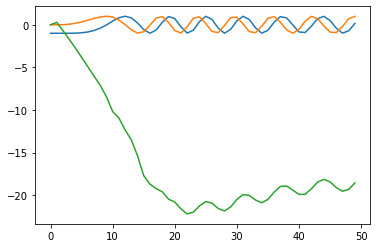

In [71]:
plt.plot(obs)

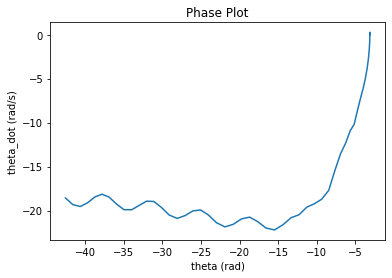

In [70]:
_ = plt.plot(theta[:100], theta_dot[:100])
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

In [74]:
all_us

[]

In [72]:
env = PendulumCustomEnv()
env.seed(0)
np.random.seed(0)

all_us = []
all_xs = []
obs = []
infos = []

split = 20
obs0, _ = env.reset(np.array([np.pi, 0]))

for i in range(50):
    obs.append(prev_obs)
    
    next_obs, reward, done, info = env.step(all_us[0][i])
    infos.append(np.array([info['th'], info['dth'], info['ddth']]))
    
    prev_obs = next_obs
    last_us = us

IndexError: list index out of range